In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import sys

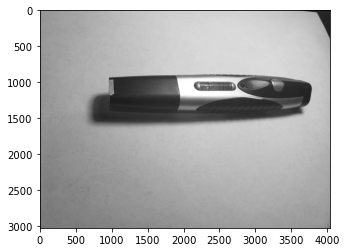

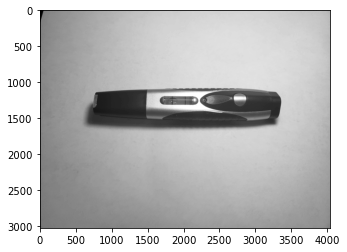

In [3]:
%matplotlib inline
# Load and display the two images
img1 = cv2.imread("test/images/pen1.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img1, cmap='gray')
plt.show()

img2 = cv2.imread("test/images/pen2.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray')
plt.show()

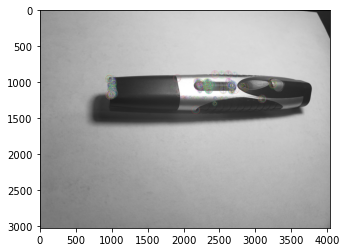

In [14]:
MAX_FEATURES = 1000

# creating the ORB feature extractor
orb = cv2.ORB_create(MAX_FEATURES)

# creating feature points for first and second images
kp1, dc1 = orb.detectAndCompute(img1, None)
kp2, dc2 = orb.detectAndCompute(img2, None)

img1_ORB = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1_ORB)
plt.show()

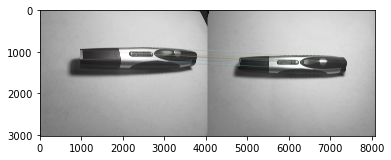

In [15]:
# most matches are not very good, so we want to keep only the best ones.
# here, we keep only the top 20%
GOOD_MATCH_PERCENT = 0.2

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# match descriptors
matches = bf.match(dc1, dc2)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove worst matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

img_match = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
plt.imshow(img_match)
plt.show()

pts1 = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
pts2 = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

In [16]:

K = np.array([[3.31666140e+03, 0.00000000e+00, 2.00701025e+03],
       [0.00000000e+00, 3.33904291e+03, 1.48586298e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])


In [17]:
# converting to pixel coordinates
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Estimate the essential matrix
E, mask = cv2.findEssentialMat(pts1,pts2,K)

# We select only inlier points
pts1_inliers = (pts1[mask.ravel()==1])
pts2_inliers = (pts2[mask.ravel()==1])

In [18]:
# Recover pose using what we've learned so far
retval, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
print(R)
print(t)

[[ 0.99187402  0.00569725 -0.12709631]
 [ 0.0020051   0.99817271  0.0603923 ]
 [ 0.12720814 -0.06015639  0.99005015]]
[[-0.10582179]
 [-0.07161618]
 [ 0.99180284]]


In [19]:
# Take initial guess of intrinsic parameters through metadata
!opensfm extract_metadata test/

# Detect features points 
!opensfm detect_features test/
# Match feature points across images
!opensfm match_features test/

# This creates "tracks" for the features. That is to say, if a feature in image 1 is matched with one in image 2,
# and in turn that one is matched with one in image 3, then it links the matches between 1 and 3. In this case, 
# it does not matter since we only have two images
!opensfm create_tracks test/

# Calculates the essential matrix, the camera pose and the reconstructed feature points
!opensfm reconstruct test/

# For visualization using Open3D
!opensfm export_ply test/

2020-07-21 14:00:56,837 INFO: Loading existing EXIF for pen1.jpg
2020-07-21 14:00:56,837 INFO: Loading existing EXIF for pen2.jpg
2020-07-21 14:00:58,825 INFO: Skip recomputing ROOT_HAHOG features for image pen1.jpg
2020-07-21 14:00:58,825 INFO: Skip recomputing ROOT_HAHOG features for image pen2.jpg
2020-07-21 14:01:00,816 INFO: Matching 1 image pairs
2020-07-21 14:01:00,822 INFO: Computing pair matching with 1 processes
2020-07-21 14:01:00,840 DEBUG: No segmentation for pen2.jpg, no features masked.
2020-07-21 14:01:00,841 DEBUG: No segmentation for pen1.jpg, no features masked.
2020-07-21 14:01:01,100 DEBUG: Matching pen2.jpg and pen1.jpg.  Matcher: FLANN (symmetric) T-desc: 0.259 T-robust: 0.001 T-total: 0.260 Matches: 162 Robust: 136 Success: True
2020-07-21 14:01:01,101 DEBUG: Image pen2.jpg matches: 1 out of 1
2020-07-21 14:01:01,101 DEBUG: Image pen1.jpg matches: 0 out of 0
2020-07-21 14:01:01,101 INFO: Matched 1 pairs for 2 ref_images (perspective-perspective: 1) in 0.28473946

In [20]:
!opensfm undistort test/

!opensfm compute_depthmaps test/

2020-07-21 14:01:14,887 DEBUG: Undistorting the reconstruction
2020-07-21 14:01:14,893 DEBUG: Undistorting image pen1.jpg
2020-07-21 14:01:17,209 DEBUG: Undistorting image pen2.jpg
2020-07-21 14:01:21,329 INFO: Computing neighbors
2020-07-21 14:01:21,336 INFO: Using precomputed raw depthmap pen1.jpg
2020-07-21 14:01:21,336 INFO: Using precomputed raw depthmap pen2.jpg
2020-07-21 14:01:21,336 INFO: Using precomputed clean depthmap pen1.jpg
2020-07-21 14:01:21,337 INFO: Using precomputed clean depthmap pen2.jpg
2020-07-21 14:01:21,337 INFO: Using precomputed pruned depthmap pen1.jpg
2020-07-21 14:01:21,337 INFO: Using precomputed pruned depthmap pen2.jpg
2020-07-21 14:01:21,337 INFO: Merging depthmaps


In [21]:
import open3d as o3d
from open3d import JVisualizer

pcd = o3d.io.read_point_cloud("test/undistorted/depthmaps/merged.ply")
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

# UNCOMMENT ONLY IF RUNNING LOCALLY
# o3d.visualization.draw_geometries([pcd])

JVisualizer with 1 geometries